# Variational Autoencoder
___
* see training - loss etc
* compare x and x_dach


In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import json

In [2]:
from pathlib import Path
path = str(Path(os.getcwd()).parent)

import sys
sys.path.insert(0,path)

from breakout.vae.vae import ConvVAE

In [3]:
obs_path = path + '/breakout/record'
LATENT_DIM = 32
vae_path = path +'/breakout/tf_vae'
trainparam_path = path + '/breakout/tf_vae/vae_train_param.json'
batch_size=230

In [3]:
# SET
server = True
if server:
    obs_path = path + '/breakout/results_200218/record'
    vae_path = path + '/breakout/results_200218/tf_vae'
    trainparam_path = path + '/breakout/results_200218/tf_vae/vae_train_param.json'
    batch_size=400

In [4]:
def load_raw_data_list(filelist):
    data_list = []
    action_list = []
    counter = 0
    for i in range(len(filelist)):
        filename = filelist[i]
        raw_data = np.load(os.path.join(obs_path, filename))
        data_list.append(raw_data['obs'])
        action_list.append(raw_data['action'])
        if ((i+1) % 1000 == 0):
            print("loading file", (i+1))
    return data_list, action_list

In [5]:
filelist = os.listdir(obs_path)
dataset, action_dataset = load_raw_data_list(filelist[0:10])
dataset[0].shape

(400, 64, 64, 3)

## Compare Input and Output of VAE

In [6]:
vae = ConvVAE(z_size=32,
              batch_size=batch_size,
              learning_rate=0.0001,
              kl_tolerance=0.5,
              is_training=False,
              reuse=False,
              gpu_mode=True)
vae.load_json(os.path.join(vae_path,'vae.json'))

obs = dataset[5]
z = vae.encode(obs) 
z_dec = vae.decode(z)

INFO:tensorflow:Model using gpu.


In [7]:
obs = np.array(obs, dtype=np.float32)

In [8]:
def plot_results(n,frame_nb, obs, z_dec):
    
    n_plots = n * 2
    i = 1
    while i < n_plots + 1:
        if i % 2 == 1:
            plt.subplot(n,2,i)
            plt.title(f"{i},{frame_nb}")
            plt.imshow(obs[frame_nb])
            plt.axis('off')
        else:
            plt.subplot(n,2,i)
            plt.title(f"{i},{frame_nb}")
            plt.imshow(z_dec[frame_nb])
            frame_nb += 1
            plt.axis('off')
        i += 1
    plt.show()    
    

In [10]:
z_dec.max()

6.64045e-06

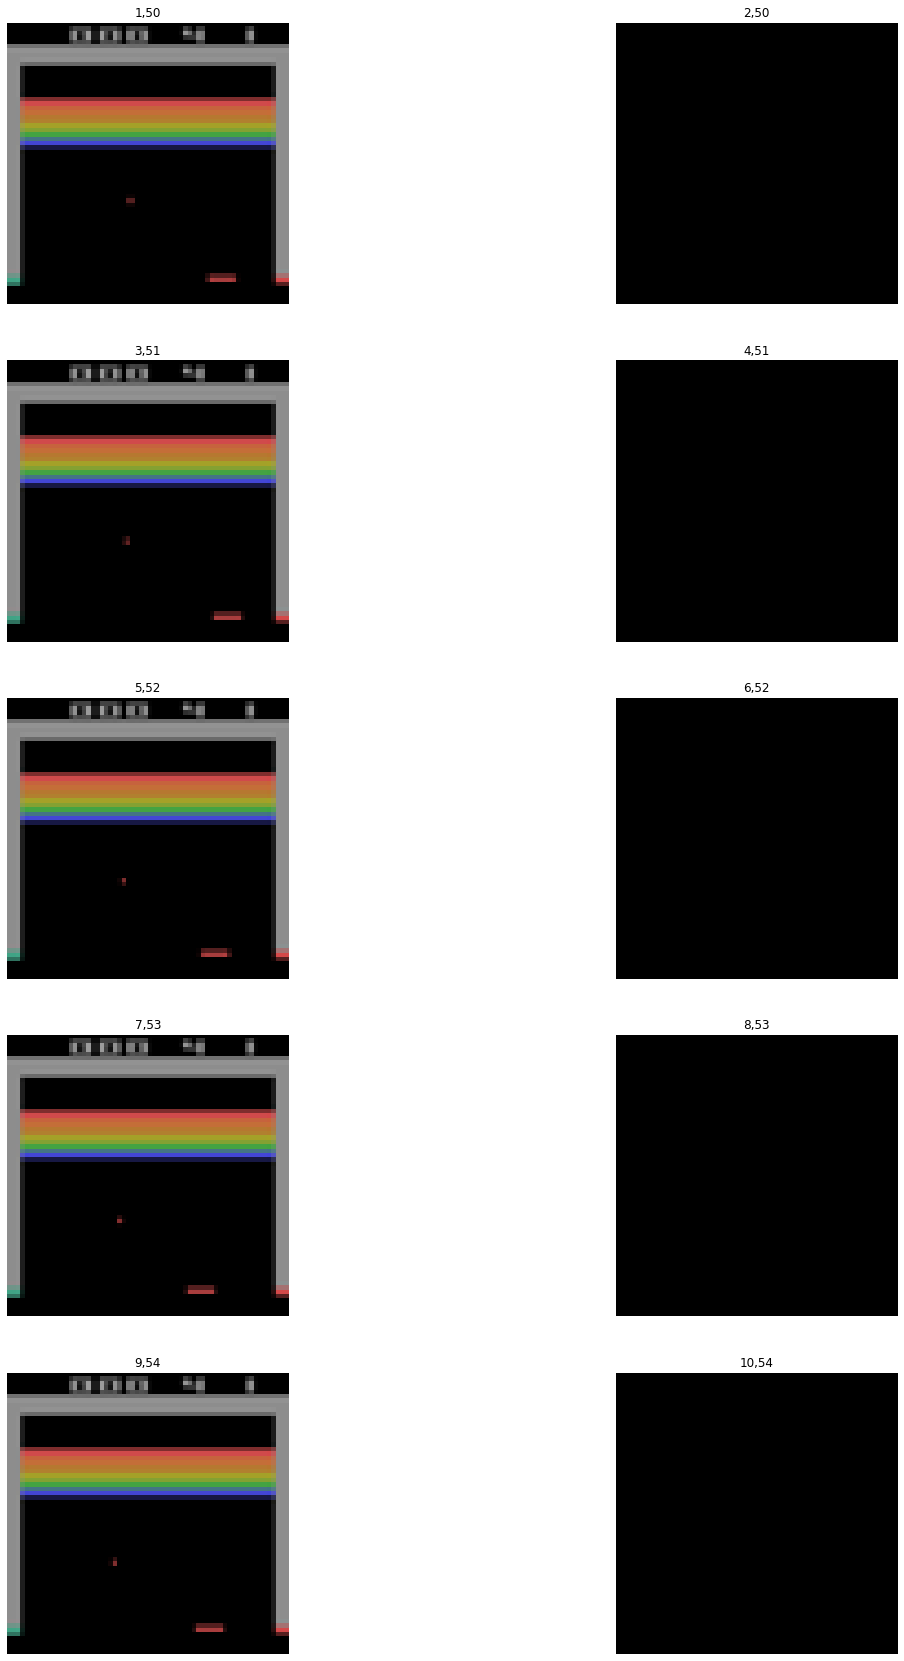

In [9]:
plt.figure(figsize=(20,30))
plot_results(n=5, frame_nb=50,obs=obs, z_dec=z_dec)

### Sample z from normal distribution

In [22]:
vae = ConvVAE(z_size=32,
              batch_size=16,
              learning_rate=0.0001,
              kl_tolerance=0.5,
              is_training=False,
              reuse=False,
              gpu_mode=True)
vae.load_json(os.path.join(vae_path,'vae.json'))

INFO:tensorflow:Model using gpu.


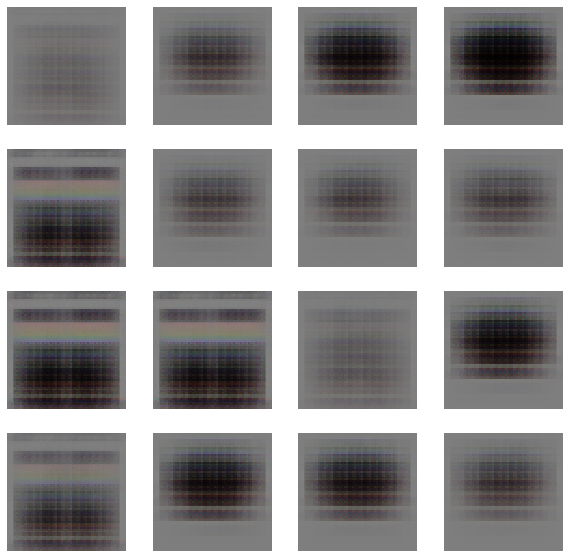

In [23]:
# z from normal distrib
num_examples_to_generate = 16
random_vec_for_generation = np.random.normal(size=(num_examples_to_generate, LATENT_DIM)) 
#tf.random_normal(shape=(num_examples_to_generate, LATENT_DIM))
z_dec = vae.decode(random_vec_for_generation)
fig = plt.figure(figsize=(10,10))
for i in range(z_dec.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(z_dec[i, :, :, :])
    plt.axis('off')
plt.show()

## Compare Mu and LogVar

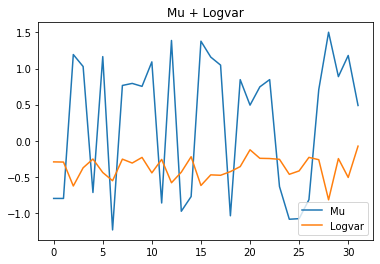

In [24]:
obs = dataset[0]
mu, logvar = vae.encode_mu_logvar(obs)
mu.shape
plt.title('Mu + Logvar')
plt.plot(mu[0], label='Mu')
plt.plot(logvar[0], label = 'Logvar')
plt.legend(loc='lower right')
plt.show()

## See Training Param

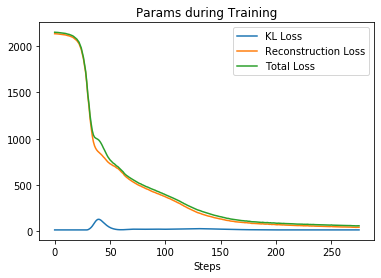

In [25]:
with open(trainparam_path, 'r') as file:
    train_param = json.load(file)
kl_loss = []
r_loss = []
train_loss = []
for item in train_param:
    kl_loss.append(item['kl_loss'])
    r_loss.append(item['r_loss'])
    train_loss.append(item['train_loss'])

plt.plot(kl_loss, label='KL Loss')
plt.plot(r_loss, label='Reconstruction Loss')
plt.plot(train_loss, label='Total Loss')
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.title('Params during Training')
plt.show()

## Video Sequence


In [ ]:
import base64
import imageio
import IPython
import pyvirtualdisplay

In [ ]:
!pip install pyvirtualdisplay

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
filename = 'video_1.mp4'
with imageio.get_writer(filename, fps=30) as video:    
    for image in range(390):
        video.append_data(dataset[0][i])
embed_mp4(filename)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:
PIL.Image.fromarray(dataset[0][6])